In [55]:
def radian_to_latlon(g16_data_file):
    
    # designate dataset
    g16nc = Dataset(g16_data_file, 'r')

    # GOES-R projection info and retrieving relevant constants
    proj_info = g16nc.variables['goes_imager_projection']
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis

    # Data info
    lat_rad_1d = g16nc.variables['x'][:]
    lon_rad_1d = g16nc.variables['y'][:]
   
    # close file when finished
    g16nc.close()
    g16nc = None

    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)

    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    # print test coordinates
    #print('{} N, {} W'.format(lat[250,250],abs(lon[250,250])))
    return lat,lon
#========== end of radian_to_latlon========================

def find_OT_edges(BT_wnd_radii,smBT_wnd_radii,BT_wvp_radii):

    OT_edge=np.zeros(Ndirection,'i')
    OT_BTwnd_sum=np.zeros(Ndirection,'f')
    OT_BT2wnd_sum=np.zeros(Ndirection,'f')
    OT_BTwvp_sum=np.zeros(Ndirection,'f')
    ci_BTwnd_sum=np.zeros(Ndirection,'f')
    ci_BT2wnd_sum=np.zeros(Ndirection,'f')
    ci_BT_num=np.zeros(Ndirection,'i')
    
    for ri in range(Ndirection):
        first_deriv = np.gradient(smBT_wnd_radii[ri,:])
        second_deriv= np.gradient(first_deriv)
        ind=np.where(second_deriv < 0)[0]
       
        #plt.plot(smBT_wnd_radii[ri,:])
        #plt.show()
        #plt.plot(first_deriv)
        #plt.show()
        #plt.plot(second_deriv)
        #plt.show()
        
        if (len(ind) ==0): # if there is no negative second_derivative, using the minimum value 
            ind=np.where(min(second_deriv) == second_deriv)
            
        OT_edge[ri]=ind[0]+1
        OT_BTwnd_sum[ri]=sum(BT_wnd_radii[ri,0:OT_edge[ri]])
        OT_BT2wnd_sum[ri]=sum(BT_wnd_radii[ri,0:OT_edge[ri]]**2)
        OT_BTwvp_sum[ri]=sum(BT_wvp_radii[ri,0:OT_edge[ri]])
        
        tpBTci=BT_wnd_radii[ri,OT_edge[ri]:win_size+1]
        cind=np.where(tpBTci < cirrus_threshold)[0]
        ci_BTwnd_sum[ri] =sum(tpBTci[cind])
        ci_BT2wnd_sum[ri]=sum(tpBTci[cind]**2)
        ci_BT_num[ri]    = len(cind)
        
        
    OT_aveBTwnd = sum(OT_BTwnd_sum)/sum(OT_edge)
    OT_aveBTwvp = sum(OT_BTwvp_sum)/sum(OT_edge)
    ci_aveBTwnd = sum(ci_BTwnd_sum)/sum(ci_BT_num)
    OTci_aveBT2wnd = (sum(OT_BT2wnd_sum)+sum(ci_BT2wnd_sum))/(sum(OT_edge)+sum(ci_BT_num))
    OTci_aveBTwnd  = (sum(OT_BTwnd_sum)+sum(ci_BTwnd_sum))/(sum(OT_edge)+sum(ci_BT_num))
    OTci_stdBTwnd  = math.sqrt(OTci_aveBT2wnd-OTci_aveBTwnd**2)
  
    return OT_aveBTwnd,OT_aveBTwvp,ci_aveBTwnd,OTci_stdBTwnd,OT_edge
#=============== end of find_OT_edges====================
    
#================= main ===========================================
from netCDF4 import Dataset
from pyhdf.SD import SD, SDC
import h5py
import numpy as np
import pandas as pd
import math
import os, os.path
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from scipy.ndimage import gaussian_filter
import glob
global win_size,Ndirection,cirrus_threshold

print('start',datetime.now())
#=========== these parameters are fixed ==========
win_size=10
Ndirection=8
cirrus_threshold=260
const =-3.2397
coef_1=0.2075
coef_2=0.3516
coef_3=0.4996

#============ change the directory for data acesses========================
data_dir  ='/data/accp/a/snesbitt/goes-mds/'
merra2_dir='/data/keeling/a/yulanh/c/MERRA-2/' # change the the

#=========================================
file_name=glob.glob(data_dir+'*RadM2-M3C08_G16_s201902509*') # change the file title here
scan_mode_flag='M3C13_G16_' # change the scan mode for window channel,which should be same as water vapor channel

print(len(file_name))

for fi in range(len(file_name)):
    G16wvp_file=file_name[fi]
    print(fi,G16wvp_file)
#11.2 um
#G16wnd_file = 'OR_ABI-L1b-RadM2-M3C14_G16_s20183160350548_e20183160351006_c20183160351053.nc'
    G16wnd_file = glob.glob(data_dir + G16wvp_file[-77:-60] + scan_mode_flag + G16wvp_file[-50:-35]+'*')
    G16wnd_file = G16wnd_file[0]
    G16wnd_exist= os.path.exists(G16wnd_file)
    if G16wnd_exist == 'Fause':
        print('No window channel file for:'+G16wvp_file)
        exist()
    
    # for record result
    wfname ='OT_C0813'+G16wnd_file[-55:-2]+'h5'

    #=== process MERRA2 data file==
    year=G16wnd_file[-49:-45]
    day =G16wnd_file[-45:-42]
    time_utchh=G16wnd_file[-42:-40]
    time_utcmm=G16wnd_file[-40:-38]
    time_utc=int(time_utchh)+int(time_utcmm)/60.0
    #print(year,day,time_utchh,time_utcmm,time_utc)
    
    #==== get year and date=====
    start_date=date(int(year),1,1)
    convt_date=start_date+timedelta(days=int(day)-1)
    date_res  = convt_date.strftime("%m%d%y")
    mmdd=date_res[0:4]
    merra2_file=merra2_dir+year+'/MERRA2_400.inst1_2d_asm_Nx.'+year+mmdd+'.nc4' # modify file name accordingly
    merra2_exist=os.path.exists(merra2_file)
    if merra2_exist == 'Fause':
        print('No MERRA2 file '+merra2_file)
        exist()
    #==== read MERRA-2 data ===
    merra2_id = Dataset(merra2_file,'r')
    merra2_tropopause_t=merra2_id.variables['TROPT'][:]
    merra2_lat=merra2_id.variables['lat'][:]
    merra2_lon=merra2_id.variables['lon'][:]
    merra2_id.close()
    merra2_id = None
        
    #===== GOES-R radiance and BT
    g16nc = Dataset(G16wvp_file,'r')
    fk1_wvp=g16nc.variables['planck_fk1'][:]
    fk2_wvp=g16nc.variables['planck_fk2'][:]
    bc1_wvp=g16nc.variables['planck_bc1'][:]
    bc2_wvp=g16nc.variables['planck_bc2'][:]
    Rad_wvp=g16nc.variables['Rad'][:]
    g16nc.close()
    g16nc = None
    lat,lon=radian_to_latlon(G16wvp_file)

    g16nc = Dataset(G16wnd_file,'r')
    fk1_wnd=g16nc.variables['planck_fk1'][:]
    fk2_wnd=g16nc.variables['planck_fk2'][:]
    bc1_wnd=g16nc.variables['planck_bc1'][:]
    bc2_wnd=g16nc.variables['planck_bc2'][:]
    Rad_wnd=g16nc.variables['Rad'][:]
    g16nc.close()
    g16nc = None

    xdim=Rad_wnd.shape[0]
    ydim=Rad_wnd.shape[1]
    OT_Area_circ  = np.zeros((xdim,ydim),'f')
    OT_probability= np.zeros((xdim,ydim),'f')
    OT_meanBTwnd  = np.zeros((xdim,ydim),'f')
    OT_meanBTwvp  = np.zeros((xdim,ydim),'f')
    ci_meanBTwnd  = np.zeros((xdim,ydim),'f')
    OTci_sigmaBTwnd = np.zeros((xdim,ydim),'f')
    colocate_tropopause_t=np.zeros((xdim,ydim),'f')

    #==== convert to BT and smooth BT====
    BT_wvp=[fk2_wvp/(np.log((fk1_wvp/Rad_wvp)+1))-bc1_wvp]/bc2_wvp
    BT_wnd=[fk2_wnd/(np.log((fk1_wnd/Rad_wnd)+1))-bc1_wnd]/bc2_wnd
    BT_wvp=BT_wvp.reshape(xdim,ydim)
    BT_wnd=BT_wnd.reshape(xdim,ydim)
    #==== Gaussian filter to smooth BT field ===
    smooth_BT_wvp = gaussian_filter(BT_wvp,sigma=1)
    smooth_BT_wnd = gaussian_filter(BT_wnd,sigma=1)
    smooth_BT_wvp=smooth_BT_wvp.reshape(xdim,ydim)
    smooth_BT_wnd=smooth_BT_wnd.reshape(xdim,ydim)

   
    #print(merra2_tropopause_t.shape)
    #xdim=335
    #ydim=236

    #====== loop for OT search ========
    for xi in range(win_size,xdim-win_size):
        for yi in range(win_size,ydim-win_size):
            #print(xi,yi)
            tp_geoslon  = lon[xi,yi]
            tp_geoslat  = lat[xi,yi]
            # obtain MERRA tropopause temperature 
            merralon_scp= round((tp_geoslon+180)/0.625) 
            merralat_scp= round((tp_geoslat+90)/0.5)
            hour_scp = round(time_utc)
            if (merralon_scp > len(merra2_lon)):
                merralon_scp = len(merra2_lon)-1
            if (merralat_scp > len(merra2_lat)):
                merralat_scp = len(merra2_lat)-1
            if (hour_scp > 23):
                hour_scp=23
            tp_tropopause_t=merra2_tropopause_t[hour_scp,merralat_scp,merralon_scp]
            colocate_tropopause_t[xi,yi]=tp_tropopause_t

            #===== start OT search ===
            if (abs(tp_geoslat) <= 25):
                BT_threshold = 200
            if (abs(tp_geoslat) > 25):
                BT_threshold = 230

            if ((BT_wnd[xi,yi] <= BT_threshold) & (BT_wnd[xi,yi] < tp_tropopause_t)):
                colupres = yi + win_size
                collowres= yi - win_size
                rowupres = xi + win_size
                rowlowres= xi - win_size
                tpbt_wnd_box=BT_wnd[rowlowres:rowupres,collowres:colupres]
                tpsmbt_wnd_box=smooth_BT_wnd[rowlowres:rowupres,collowres:colupres]
                tpbt_wvp_box=BT_wvp[rowlowres:rowupres,collowres:colupres]
                #print(xi,yi,BT_wnd[xi,yi],np.min(tpbt_wnd_box))
                if (BT_wnd[xi,yi] == np.min(tpbt_wnd_box)): #only if the pixel is colder in the window, go to next step
                    # obtain 8 vectors in 8 directions
                    BT_wnd_radii=np.zeros((8,win_size),'f')
                    smBT_wnd_radii=np.zeros((8,win_size),'f')
                    BT_wvp_radii=np.zeros((8,win_size),'f')

                    BT_wnd_radii[0,:]=BT_wnd[xi,yi:yi+win_size]
                    BT_wnd_radii[1,:]=np.diagonal(BT_wnd[xi:xi+win_size,yi:yi+win_size])
                    BT_wnd_radii[2,:]=BT_wnd[xi:xi+win_size,yi]
                    BT_wnd_radii[3,:]=np.diagonal(np.fliplr(BT_wnd[xi:xi+win_size,yi-win_size+1:yi+1]).transpose())
                    BT_wnd_radii[4,:]=BT_wnd[xi,yi-win_size+1:yi+1][::-1]
                    BT_wnd_radii[5,:]=np.diagonal(BT_wnd[xi-win_size+1:xi+1,yi-win_size+1:yi+1])[::-1]
                    BT_wnd_radii[6,:]=BT_wnd[xi-win_size+1:xi+1,yi][::-1]
                    BT_wnd_radii[7,:]=np.diagonal(np.fliplr(BT_wnd[xi-win_size+1:xi+1,yi:yi+win_size]))[::-1]

                    smBT_wnd_radii[0,:]=smooth_BT_wnd[xi,yi:yi+win_size]
                    smBT_wnd_radii[1,:]=np.diagonal(smooth_BT_wnd[xi:xi+win_size,yi:yi+win_size])
                    smBT_wnd_radii[2,:]=smooth_BT_wnd[xi:xi+win_size,yi]
                    smBT_wnd_radii[3,:]=np.diagonal(np.fliplr(smooth_BT_wnd[xi:xi+win_size,yi-win_size+1:yi+1]).transpose())
                    smBT_wnd_radii[4,:]=smooth_BT_wnd[xi,yi-win_size+1:yi+1][::-1]
                    smBT_wnd_radii[5,:]=np.diagonal(smooth_BT_wnd[xi-win_size+1:xi+1,yi-win_size+1:yi+1])[::-1]
                    smBT_wnd_radii[6,:]=smooth_BT_wnd[xi-win_size+1:xi+1,yi][::-1]
                    smBT_wnd_radii[7,:]=np.diagonal(np.fliplr(smooth_BT_wnd[xi-win_size+1:xi+1,yi:yi+win_size]))[::-1]

                    BT_wvp_radii[0,:]=BT_wvp[xi,yi:yi+win_size]
                    BT_wvp_radii[1,:]=np.diagonal(BT_wvp[xi:xi+win_size,yi:yi+win_size])
                    BT_wvp_radii[2,:]=BT_wvp[xi:xi+win_size,yi]
                    BT_wvp_radii[3,:]=np.diagonal(np.fliplr(BT_wvp[xi:xi+win_size,yi-win_size+1:yi+1]).transpose())
                    BT_wvp_radii[4,:]=BT_wvp[xi,yi-win_size+1:yi+1][::-1]
                    BT_wvp_radii[5,:]=np.diagonal(BT_wvp[xi-win_size+1:xi+1,yi-win_size+1:yi+1])[::-1]
                    BT_wvp_radii[6,:]=BT_wvp[xi-win_size+1:xi+1,yi][::-1]
                    BT_wvp_radii[7,:]=np.diagonal(np.fliplr(BT_wvp[xi-win_size+1:xi+1,yi:yi+win_size]))[::-1]

                    #calculate the gradient and obtain OT edges, mean BTs 
                    OT_aveBTwnd,OT_aveBTwvp,ci_aveBTwnd,OTci_stdBTwnd,OT_edge = \
                    find_OT_edges(BT_wnd_radii,smBT_wnd_radii,BT_wvp_radii)

                    #==== to calculate probability and OT area ====
                    if ((OT_aveBTwvp > OT_aveBTwnd) & (ci_aveBTwnd > OT_aveBTwnd)):
                        radii_mean=2*np.mean(OT_edge)
                        tpot_area=math.pi*radii_mean**2

                        tpfx=const+coef_1*(ci_aveBTwnd-BT_wnd[xi,yi])+coef_2*(tp_tropopause_t-BT_wnd[xi,yi])+\
                        coef_3*(OT_aveBTwvp-OT_aveBTwnd)
                        tpot_prob=1.0/(1+math.exp(0.0-tpfx))

                        OT_Area_circ[xi,yi]  = tpot_area
                        OT_probability[xi,yi]= tpot_prob
                        OT_meanBTwnd[xi,yi]  = OT_aveBTwnd
                        OT_meanBTwvp[xi,yi]  = OT_aveBTwvp
                        ci_meanBTwnd[xi,yi]  = ci_aveBTwnd
                        OTci_sigmaBTwnd[xi,yi]= OTci_stdBTwnd

    #==== to record the results ======
    hf=h5py.File(wfname,'w')
    hf.create_dataset('OTA_circle',data= OT_Area_circ)
    hf.create_dataset('OT_probability',data= OT_probability)
    hf.create_dataset('lat',data=lat)
    hf.create_dataset('lon',data=lon)
    hf.create_dataset('OT_meanBTwnd',data=OT_meanBTwnd)
    hf.create_dataset('OT_meanBTwvp',data=OT_meanBTwvp)
    hf.create_dataset('ci_meanBTwnd',data=ci_meanBTwnd)
    hf.create_dataset('OTci_stdBTwnd',data=OTci_stdBTwnd)
    hf.close()

print('finish',datetime.now())




start 2021-12-13 23:40:34.583877


<ipython-input-55-173cd7b4fc0a>:172: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  Rad_wvp=g16nc.variables['Rad'][:]
<ipython-input-55-173cd7b4fc0a>:182: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  Rad_wnd=g16nc.variables['Rad'][:]


60
0 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250947543_e20190250948000_c20190250948040.nc
1 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250922543_e20190250923000_c20190250923039.nc
2 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250945543_e20190250946000_c20190250946039.nc
3 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250912543_e20190250913000_c20190250913039.nc
4 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250958543_e20190250959000_c20190250959040.nc
5 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250942543_e20190250943000_c20190250943039.nc
6 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250927543_e20190250928000_c20190250928040.nc
7 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250949543_e20190250950000_c20190250950040.nc
8 /data/accp/a/snesbitt/goes-mds/OR_ABI-L1b-RadM2-M3C08_G16_s20190250940543_e20190250941000_c20190250941041.n

In [47]:
#print(data_dir + G16wvp_file[-77:-60] + 'M6C13_G16_'+ G16wvp_file[-50:-35])
print(len(file_name))
print( G16wvp_file[-40:-38],G16wvp_file)

60
06 /data/accp/a/snesbitt/goes-mds-tornado/OR_ABI-L1b-RadM2-M6C08_G16_s20213450706261_e20213450706318_c20213450706365.nc


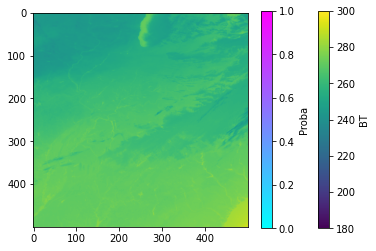

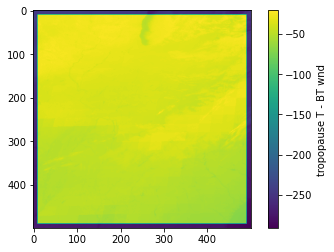

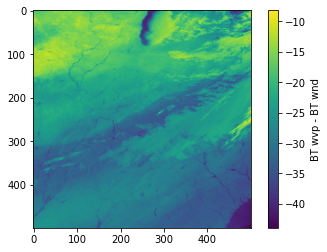

In [56]:
%matplotlib inline
p0=plt.imshow(BT_wnd,vmin=180,vmax=300)
#plt.xlim([200,350])
#plt.ylim([100,250])
plt.colorbar(p0,label='BT')
index=np.where(OT_probability > 0)
xy=np.array(index)
x=xy.tolist()
colors=OT_probability[index]
p1=plt.scatter(x[1],x[0],s=20,c=colors,cmap=plt.get_cmap('cool'),vmin=0,vmax=1)
plt.colorbar(p1,label='Proba') 
plt.show()

a11=colocate_tropopause_t-BT_wnd
p2=plt.imshow(a11)#,vmin=180,vmax=300)
plt.colorbar(p2,label='tropopause T - BT wnd')
index=np.where(a11 > 0)
xy=np.array(index)
x=xy.tolist()
p21=plt.scatter(x[1],x[0],s=20,c='grey')#,c=colors,cmap=plt.get_cmap('cool'),vmin=0,vmax=1)
plt.show()

a21=BT_wvp-BT_wnd
p3=plt.imshow(BT_wvp-BT_wnd)#,vmin=180,vmax=300)
plt.colorbar(p3,label='BT wvp - BT wnd')
index=np.where(a21 > 0)
xy=np.array(index)
x=xy.tolist()
p31=plt.scatter(x[1],x[0],s=20,c='grey')
plt.show()


In [34]:
import pandas as pd
df=pd.DataFrame(tpbt_wnd_box)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,226.093750,226.432159,226.566986,225.273773,223.386810,222.311874,222.021881,215.968033,210.962906,210.425919,212.627335,217.089935,217.089935,218.576797,217.169189,211.933044,210.784531,209.609619,207.841537,208.779907
1,224.232849,225.616791,226.701523,226.025833,225.204956,221.949127,213.820633,209.334564,208.030624,209.334564,211.670258,214.156662,212.107498,208.406693,206.007782,205.014053,205.014053,205.810669,205.909332,204.509338
2,214.240341,219.949829,220.175461,215.887009,216.531876,215.480057,210.695129,208.312943,208.872772,210.155258,209.242569,208.593628,206.788300,204.812805,204.101685,203.793625,204.101685,204.407761,204.610718,203.793625
3,208.030624,207.173904,206.788300,207.556519,210.605530,211.051849,209.700974,209.242569,209.792160,209.242569,206.007782,205.314346,204.203934,203.171341,203.171341,203.690475,204.812805,204.101685,203.587112,203.379700
4,207.841537,206.497070,205.414001,205.810669,206.884979,210.064728,210.515793,209.334564,208.779907,207.077789,204.509338,203.587112,201.252991,201.470123,200.925323,201.361679,202.751862,203.483536,202.222122,202.222122
5,206.788300,206.399597,206.497070,207.936172,207.746704,209.792160,210.695129,208.779907,207.269836,204.913544,202.222122,200.925323,199.250504,200.039841,200.373947,200.151489,200.151489,200.925323,201.578323,202.540695
6,203.793625,203.896515,203.171341,204.812805,206.691406,209.150375,209.883179,208.312943,205.314346,201.578323,199.815735,200.151489,198.678009,198.907898,200.705582,200.705582,200.373947,199.815735,200.925323,202.540695
7,200.705582,199.590485,198.907898,199.927933,203.379700,207.936172,209.792160,207.173904,202.115448,199.136597,197.510269,198.214615,198.907898,200.595306,201.144028,201.470123,201.252991,200.815598,201.361679,201.361679
8,195.943863,196.553055,198.446930,199.250504,200.151489,206.497070,208.593628,204.913544,199.815735,197.746307,195.943863,196.066406,198.678009,200.595306,201.793915,201.470123,200.595306,200.373947,201.034821,199.477448
9,195.820984,195.076157,195.076157,196.431915,199.477448,205.114349,206.788300,202.222122,197.628464,196.188583,192.493530,193.023056,197.746307,200.484741,202.222122,201.686249,199.927933,199.022385,199.364120,198.098007


In [6]:
a=(BT_wnd[xi-global_var.win_size+1:xi+1,yi:yi+global_var.win_size])
df=pd.DataFrame(a)
df
b=np.fliplr(BT_wnd[xi-global_var.win_size+1:xi+1,yi:yi+global_var.win_size])
df1=pd.DataFrame(b)
df1

,0,1,2,3,4,5,6,7,8,9
0,204.509338,205.909332,205.810669,205.014053,205.014053,206.007782,208.406693,212.107498,214.156662,211.670258
1,203.793625,204.610718,204.407761,204.101685,203.793625,204.101685,204.812805,206.788300,208.593628,209.242569
2,203.379700,203.587112,204.101685,204.812805,203.690475,203.171341,203.171341,204.203934,205.314346,206.007782
3,202.222122,202.222122,203.483536,202.751862,201.361679,200.925323,201.470123,201.252991,203.587112,204.509338
4,202.540695,201.578323,200.925323,200.151489,200.151489,200.373947,200.039841,199.250504,200.925323,202.222122
5,202.540695,200.925323,199.815735,200.373947,200.705582,200.705582,198.907898,198.678009,200.151489,199.815735
6,201.361679,201.361679,200.815598,201.252991,201.470123,201.144028,200.595306,198.907898,198.214615,197.510269
7,199.477448,201.034821,200.373947,200.595306,201.470123,201.793915,200.595306,198.678009,196.066406,195.943863
8,198.098007,199.364120,199.022385,199.927933,201.686249,202.222122,200.484741,197.746307,193.023056,192.493530
9,197.628464,198.907898,199.250504,200.039841,201.578323,202.222122,200.484741,196.553055,189.879669,188.725830


<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<ipython-input-21-4fee9fdbc122>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  a=[1,2,3,4,5,6][1,2,3]


TypeError: list indices must be integers or slices, not tuple